In [1]:
from _context import vugrad
import numpy as np
from argparse import ArgumentParser
import vugrad as vg
import matplotlib.pyplot as plt

In [2]:
(xtrain, ytrain), (xval, yval), num_classes = vg.load_mnist(final=False, flatten=True)

print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')

#normalize
xtrain = xtrain/255
xval = xval/255

num_instances, num_features = xtrain.shape

## loaded data:
         number of instances: 55000 in training, 5000 in validation
 training class distribution: [5434 6212 5465 5622 5343 4963 5436 5702 5357 5466]
     val. class distribution: [489 530 493 509 499 458 482 563 494 483]


In [3]:
class MLP(vg.Module):
    def __init__(self, input_size, output_size, hidden_mult=None, layer=False):
        self.layer = layer
        self.hidden_size = hidden_mult * input_size
        self.layer1 = vg.Linear(input_size, self.hidden_size)
        # if self.layer == True:
        #     self.layer1_5 = vg.Linear(self.hidden_size, self.hidden_size)
        self.layer2 = vg.Linear(self.hidden_size, output_size)

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)
        # non-linearity
        hidden = vg.sigmoid(hidden)

        # if self.layer == True:
        #     hidden = self.layer1_5(hidden)
        #     hidden = vg.sigmoid(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        return output

    def parameters(self):
        # if self.layer:
        #     return self.layer1.parameters() + self.layer1_5.parameters() + self.layer2.parameters()
        # else:
        return self.layer1.parameters() + self.layer2.parameters()

In [4]:
def experiment(num_features, num_classes, epochs, lr, batch_size, hiddenmult, extra_layer=True):
    epoch_list = []
    acc_list = []
    if extra_layer:
        print('Layer = true')
        mlp = MLP(input_size=num_features, output_size=num_classes, hidden_mult=hiddenmult, layer=True)
    else:
        mlp = MLP(input_size=num_features, output_size=num_classes, hidden_mult=hiddenmult, layer=False)
    
    n, m = xtrain.shape
    b = batch_size

    print('\n## Starting training')
    for epoch in range(epochs):
        print(f'epoch {epoch:03}')
        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value
        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]
        epoch_list.append(epoch+1)
        acc_list.append(acc)

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')

        cl = 0.0 # running sum of the training loss
        # batch loop
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)
            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            cl += loss.value
            loss.backward()

            # Apply gradient descent
            for parm in mlp.parameters():
                parm.value -= lr * parm.grad
            loss.zero_grad()
            loss.clear()
        print(f'   running loss: {cl/n:.4}')
    return epoch_list, acc_list

epochs = 20
#default batchsize
batch_size = 128
lr = 0.001
hiddenmult = 2
epoch_list, acc_list2 = experiment(num_features, num_classes, epochs, lr, batch_size, hiddenmult, extra_layer=True)
hiddenmult = 4
epoch_list, acc_list4 = experiment(num_features, num_classes, epochs, lr, batch_size, hiddenmult, extra_layer=True)
hiddenmult = 6
epoch_list, acc_list6 = experiment(num_features, num_classes, epochs, lr, batch_size, hiddenmult, extra_layer=True)

Layer = true

## Starting training
epoch 000
       accuracy: 0.1782


/Users/tiddo/Documents/Msc Artificial Intelligence/Deep Learning/Assignment2/vugrad/vugrad/ops.py:180: RuntimeWarning: overflow encountered in exp
  sigx =  1 / (1 + np.exp(-input))


   running loss: 0.59
epoch 001
       accuracy: 0.932
   running loss: 0.2949
epoch 002
       accuracy: 0.9408
   running loss: 0.2542
epoch 003
       accuracy: 0.9454
   running loss: 0.2372
epoch 004
       accuracy: 0.9386
   running loss: 0.2244
epoch 005
       accuracy: 0.934
   running loss: 0.2278
epoch 006
       accuracy: 0.9482
   running loss: 0.2379
epoch 007
       accuracy: 0.9424
   running loss: 0.2481
epoch 008
       accuracy: 0.952
   running loss: 0.2302
epoch 009
       accuracy: 0.9476
   running loss: 0.2203
epoch 010
       accuracy: 0.9408
   running loss: 0.2576
epoch 011
       accuracy: 0.9316
   running loss: 0.2502
epoch 012
       accuracy: 0.9326
   running loss: 0.2281
epoch 013
       accuracy: 0.9366
   running loss: 0.2484
epoch 014
       accuracy: 0.928
   running loss: 0.2644
epoch 015
       accuracy: 0.9466
   running loss: 0.2323
epoch 016
       accuracy: 0.943
   running loss: 0.228
epoch 017
       accuracy: 0.9516
   running loss: 0.260

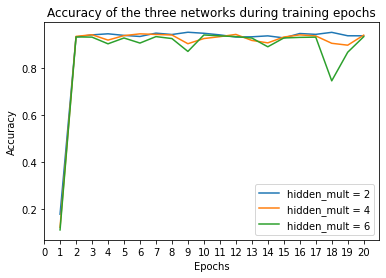

In [7]:
y1 = acc_list2
x1 = epoch_list
plt.plot(x1, y1, label = "hidden_mult = 2")
y2 = acc_list4
x2 = epoch_list
plt.plot(x2, y2, label = "hidden_mult = 4")
y3 = acc_list6
x3 = epoch_list
plt.plot(x3, y3, label = "hidden_mult = 6")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of the three networks during training epochs')
plt.xticks(np.arange(0,21, 1.0))
plt.legend()
plt.savefig('figures/Q10-hiddenmult-shorteraxis')
plt.show()